# Konwolucyjny spiętrzony klasyfikator LSTM nastroju

Ten notatnik implementuje sieć złożoną z warstwy LSTM i konwolucyjnej, do klasyfikowania nastroju recencji filmów z bazy IMDb.

#### Załadowanie zależności.


In [ ]:
import keras
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, SpatialDropout1D, LSTM
from keras.layers.wrappers import Bidirectional 
from keras.layers import Conv1D, MaxPooling1D 
from keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score 
import matplotlib.pyplot as plt 
%matplotlib inline

Using TensorFlow backend.


#### Ustawienie hiperparametrów.


In [ ]:
# Nazwa katalogu wyjściowego:
output_dir = 'model_output/cnnLSTM'

# Trening:
epochs = 4
batch_size = 128

# Osadzanie wektorów słów:
n_dim = 64 
n_unique_words = 10000 
max_review_length = 200 
pad_type = trunc_type = 'pre'
drop_embed = 0.2 

# Architektura warstwy konwolucyjnej:
n_conv = 64  
k_conv = 3 
mp_size = 4

# Architektura warstwy LSTM:
n_lstm = 64 
drop_lstm = 0.2

#### Załadowanie danych.


In [ ]:
(x_train, y_train), (x_valid, y_valid) = imdb.load_data(num_words=n_unique_words)

#### Wstępne przetworzenie danych.


In [ ]:
x_train = pad_sequences(x_train, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
x_valid = pad_sequences(x_valid, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)

#### Architektura sieci neuronowej.


In [ ]:
model = Sequential()
model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length)) 
model.add(SpatialDropout1D(drop_embed))
model.add(Conv1D(n_conv, k_conv, activation='relu'))
model.add(MaxPooling1D(mp_size))
model.add(Bidirectional(LSTM(n_lstm, dropout=drop_lstm)))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Liczba parametrów warstwy LSTM jest dwukrotnie większa, ponieważ odczytywanie jest dwukierunkowe.
model.summary() 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 64)           640000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 200, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 198, 64)           12352     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 49, 64)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 718,529
Trainable params: 718,529
Non-trainable params: 0
_________________________________________________________________


#### Konfiguracja modelu.


In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#### Trening!


In [ ]:
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_valid, y_valid), callbacks=[modelcheckpoint])

Train on 25000 samples, validate on 25000 samples
Epoch 1/4
25000/25000 [==============================] - 17s 680us/step - loss: 0.4530 - acc: 0.7620 - val_loss: 0.3147 - val_acc: 0.8705
Epoch 2/4
25000/25000 [==============================] - 16s 627us/step - loss: 0.2436 - acc: 0.9032 - val_loss: 0.3291 - val_acc: 0.8710
Epoch 3/4
25000/25000 [==============================] - 16s 625us/step - loss: 0.1734 - acc: 0.9356 - val_loss: 0.3313 - val_acc: 0.8587
Epoch 4/4
25000/25000 [==============================] - 16s 621us/step - loss: 0.1307 - acc: 0.9525 - val_loss: 0.3380 - val_acc: 0.8532


#### Ocena.

In [ ]:
model.load_weights(output_dir+"/weights.02.hdf5") 

In [ ]:
y_hat = model.predict_proba(x_valid)

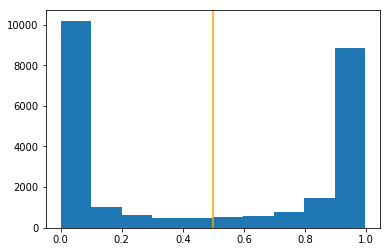

In [ ]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [ ]:
"{:0.2f}".format(roc_auc_score(y_valid, y_hat)*100.0)

'94.46'